In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import statsmodels.formula.api as smf

# GS

In [21]:
df_info = pd.read_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/GS/relationship_information/relatives.formatted.info",
    sep = "\t"
)
df_info.head()

,DOR,rcode,relationship,volid,relid,volage,relage,volsex,relsex,Erx
0,1,SB,daughter-sister,18826,21244,50,36,F,F,0.750000
1,1,SB,different-sex-sibling,34422,23884,33,35,F,M,0.353553
2,1,PC,daughter-mother,79198,67531,66,44,F,F,0.500000
3,1,SB,daughter-sister,20399,67531,38,44,F,F,0.750000
4,1,SB,daughter-sister,67267,67531,43,44,F,F,0.750000


In [22]:
pheno_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/GS/phenotype"
pheno_fns = os.listdir(pheno_path)

def load_pheno(fn):
    df_pheno = pd.read_csv(
        os.path.join(pheno_path, fn),
        sep = "\t",
        names = ["eid", "iid", "pheno"]
    )
    return df_pheno.drop("iid", axis=1)

In [23]:
df_sd_X = pd.DataFrame(columns=[
    "pheno", "Vp", "se_Vp", "Va", "se_Va", "Vx", "se_Vx"])

def merge_pheno_and_info(df_pheno, df_info):
    df_mrg = pd.merge(
        df_info,
        df_pheno.rename(columns={"eid": "volid", "pheno": "volpheno"}),
        on = "volid"
    )
    df_mrg = pd.merge(
        df_mrg,
        df_pheno.rename(columns={"eid": "relid", "pheno": "relpheno"}),
        on = "relid"
    )
    
    return df_mrg

for pheno_fn in tqdm(pheno_fns):
    df_pheno = load_pheno(f"{pheno_path}/{pheno_fn}")
    
    # merge with df_info
    df_mrg = merge_pheno_and_info(df_pheno, df_info)
    
    # add genetic relatedness
    df_mrg["Era"] = 0.5**df_mrg["DOR"]
    df_mrg["SD"] = (df_mrg["volpheno"] - df_mrg["relpheno"])**2
    df_reg = df_mrg[["SD", "Era", "Erx"]].dropna()
    
    # regression
    ll = smf.ols("SD ~ 1 + Era + Erx", data=df_reg).fit()
    
    df_sd_X.loc[len(df_sd_X)] = [
        pheno_fn.split(".")[0],
        ll.params["Intercept"] / 2,
        ll.bse["Intercept"] / 2,
        ll.params["Era"] / -2,
        ll.bse["Era"] / 2,
        ll.params["Erx"] / -2,
        ll.bse["Erx"] / 2
    ]



100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


In [24]:
df_sd_X

,pheno,Vp,se_Vp,Va,se_Va,Vx,se_Vx
0,QT_interval,0.098315,0.524076,-0.590814,1.690426,-0.364708,1.037493
1,PR_interval,1.334022,0.210661,-0.371317,0.679495,0.733072,0.417038
2,FVC,1.048619,0.021994,0.320778,0.070288,0.355228,0.042748
3,HDL_cholesterol,0.836932,0.018777,0.526268,0.060151,-0.252718,0.036783
4,Creat_mgdl,0.615057,0.095031,-0.364007,0.304668,-0.020272,0.186237
5,max_arm,0.745933,0.022404,-0.277055,0.072291,0.005251,0.044398
6,LVMI_Rautaharju,0.995745,0.072693,0.822402,0.234474,-0.659006,0.143907
7,Glucose,0.551128,0.090321,-0.783322,0.289638,0.010070,0.177199
8,avg_hr,1.005594,0.018494,0.223020,0.059716,0.117130,0.036676
9,FEF,1.100815,0.025368,0.098810,0.080999,0.452977,0.049269


<Axes: >

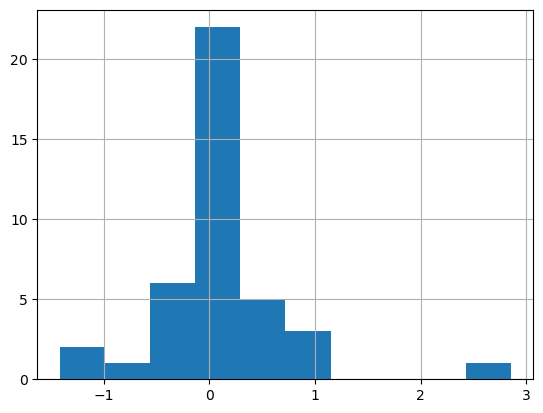

In [25]:
df_sd_X["Vx"].hist()

In [26]:
df_sd_X[np.abs(df_sd_X["Vx"] / df_sd_X["se_Vx"]) > 1.96]

,pheno,Vp,se_Vp,Va,se_Va,Vx,se_Vx
2,FVC,1.048619,0.021994,0.320778,0.070288,0.355228,0.042748
3,HDL_cholesterol,0.836932,0.018777,0.526268,0.060151,-0.252718,0.036783
6,LVMI_Rautaharju,0.995745,0.072693,0.822402,0.234474,-0.659006,0.143907
8,avg_hr,1.005594,0.018494,0.223020,0.059716,0.117130,0.036676
9,FEF,1.100815,0.025368,0.098810,0.080999,0.452977,0.049269
17,max_leg,0.820613,0.020832,-0.298304,0.067179,0.214385,0.041272
20,expected,1.011088,0.014849,0.650265,0.047916,0.290980,0.029404
21,Total_cholesterol,0.939015,0.019546,0.016124,0.062649,0.152763,0.038280
22,Potassium,0.916331,0.059160,0.353575,0.189633,-0.296072,0.115966
23,abpi,0.993720,0.024585,-0.003566,0.079288,0.136605,0.048708


In [27]:
df_sd_X.to_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/GS.he-sd-x.tsv",
    sep = "\t",
    index = False
)


# UKB

In [5]:
df_info = pd.read_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/relationship_information/relatives.formatted.info",
    sep = "\t"
)
df_info.head()

,DOR,rcode,relationship,volid,relid,volage,relage,volsex,relsex,Erx
0,1,SB,daughter-sister,1000094,3653174,65,64,F,F,0.75
1,1,NaN,NaN,1000220,1691267,64,64,F,F,NaN
2,1,NaN,NaN,1000286,1571411,53,70,F,F,NaN
3,1,NaN,NaN,1000295,1045127,60,41,F,F,NaN
4,1,NaN,NaN,1000476,3599303,50,51,F,M,NaN


In [3]:
pheno_path = "/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/phenotype"
pheno_fns = os.listdir(pheno_path)

def load_pheno(fn):
    df_pheno = pd.read_csv(
        os.path.join(pheno_path, fn),
        sep = "\t",
        names = ["eid", "iid", "pheno"]
    )
    return df_pheno.drop("iid", axis=1)

In [14]:
df_sd_X = pd.DataFrame(columns=[
    "pheno", "Vp", "se_Vp", "Va", "se_Va", "Vx", "se_Vx"])

def merge_pheno_and_info(df_pheno, df_info):
    df_mrg = pd.merge(
        df_info,
        df_pheno.rename(columns={"eid": "volid", "pheno": "volpheno"}),
        on = "volid"
    )
    df_mrg = pd.merge(
        df_mrg,
        df_pheno.rename(columns={"eid": "relid", "pheno": "relpheno"}),
        on = "relid"
    )
    
    return df_mrg

for pheno_fn in tqdm(pheno_fns):
    df_pheno = load_pheno(f"{pheno_path}/{pheno_fn}")
    
    # merge with df_info
    df_mrg = merge_pheno_and_info(df_pheno, df_info)
    
    # add genetic relatedness
    df_mrg["Era"] = 0.5**df_mrg["DOR"]
    df_mrg["SD"] = (df_mrg["volpheno"] - df_mrg["relpheno"])**2
    df_reg = df_mrg[["SD", "Era", "Erx"]].dropna()
    
    # regression
    ll = smf.ols("SD ~ 1 + Era + Erx", data=df_reg).fit()
    
    df_sd_X.loc[len(df_sd_X)] = [
        pheno_fn.split(".")[0],
        ll.params["Intercept"] / 2,
        ll.bse["Intercept"] / 2,
        ll.params["Era"] / -2,
        ll.bse["Era"] / 2,
        ll.params["Erx"] / -2,
        ll.bse["Erx"] / 2
    ]



100%|██████████| 106/106 [00:35<00:00,  2.96it/s]


In [15]:
df_sd_X

,pheno,Vp,se_Vp,Va,se_Va,Vx,se_Vx
0,White_blood_cell__leukocyte__count,1.049521,0.262606,-0.974885,1.347341,1.029858,0.854720
1,Lymphocyte_count,1.194720,0.735070,-3.208162,3.772191,2.799017,2.392761
2,Trunk_fat-free_mass,1.009339,0.015485,0.154536,0.079504,0.634225,0.050405
3,Whole_body_water_mass,1.031493,0.016461,0.157103,0.084522,0.688964,0.053582
4,HDL_cholesterol,0.988001,0.017906,0.898608,0.091487,-0.303495,0.058115
...,...,...,...,...,...,...,...
101,Sitting_height,0.980985,0.020525,0.556117,0.105245,0.122899,0.066721
102,Alkaline_phosphatase,0.939828,0.052459,0.839158,0.269763,-0.340785,0.171046
103,Platelet_crit,0.985277,0.026144,0.541205,0.134142,-0.107994,0.085099
104,Calcium,1.022732,0.021700,0.594095,0.110871,-0.221585,0.070422


In [20]:
df_sd_X.to_csv(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/supple/UKB.he-sd-x.tsv",
    sep = "\t",
    index = False
)
